In [1]:
import osmnx as ox
from osmnx import geometries as geom
import networkx as nx
import numpy as np
import pandas as pd
import geopandas 
from geopandas import GeoDataFrame 
import time
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.spatial.distance import squareform, pdist
from sklearn.cluster import DBSCAN

ox.config(use_cache=True, log_console=True)

2022-01-25 18:12:16 Configured OSMnx 1.1.2
2022-01-25 18:12:16 HTTP response caching is on


In [2]:
# parameterize DBSCAN
eps = 300 #meters
minpts = 10 #smallest cluster size allowed
pseudo_minpts = 1 #we're clustering nodes, not firms, so throw nothing away as noise: a single node might be alone,
                  #but may contain a hundred points as they're nearest node.

place = 'Amsterdam, Netherlands'

2022-01-25 18:12:20 Retrieved response from cache file "cache/419b359cb4476574b3cb66d659f50010ff747e3c.json"
2022-01-25 18:12:20 Created GeoDataFrame with 1 rows from 1 queries
2022-01-25 18:12:20 Constructed place geometry polygon(s) to query API
2022-01-25 18:12:20 Projected GeoDataFrame to +proj=utm +zone=31 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2022-01-25 18:12:21 Projected GeoDataFrame to epsg:4326
2022-01-25 18:12:21 Projected GeoDataFrame to +proj=utm +zone=31 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2022-01-25 18:12:21 Projected GeoDataFrame to epsg:4326
2022-01-25 18:12:21 Requesting data within polygon from API in 1 request(s)
2022-01-25 18:12:21 Retrieved response from cache file "cache/68ff61766e393ae5587c7efe1f64d55b37e822c1.json"
2022-01-25 18:12:21 Got all network data within polygon from API in 1 request(s)
2022-01-25 18:12:21 Creating graph from downloaded OSM data...
2022-01-25 18:12:23 Created graph with 81155 nodes and 135454 edges
2022-

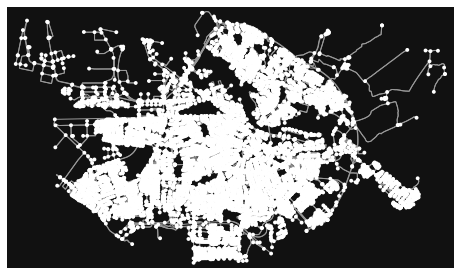

2022-01-25 18:12:52 Finished plotting the graph


(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [3]:
# get the street network
G = ox.graph_from_place(place, network_type='drive')
ox.plot_graph(G)


In [4]:
print(len(G.nodes))
print(len(G.edges))

12175
28165


In [5]:
#add edge travel times

G = ox.speed.add_edge_speeds(G)
G = ox.speed.add_edge_travel_times(G)


2022-01-25 18:12:58 Created edges GeoDataFrame from graph
2022-01-25 18:13:01 Created edges GeoDataFrame from graph


In [6]:
#find the bars in the place

tags = {"amenity": "bar"}
bars = ox.geometries_from_place(place, tags)

2022-01-25 18:13:05 Retrieved response from cache file "cache/419b359cb4476574b3cb66d659f50010ff747e3c.json"
2022-01-25 18:13:05 Created GeoDataFrame with 1 rows from 1 queries
2022-01-25 18:13:05 Constructed place geometry polygon(s) to query API
2022-01-25 18:13:05 Projected GeoDataFrame to +proj=utm +zone=31 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2022-01-25 18:13:05 Projected GeoDataFrame to epsg:4326
2022-01-25 18:13:05 Requesting data within polygon from API in 1 request(s)
2022-01-25 18:13:05 Retrieved response from cache file "cache/a12b25b27c819d6bbe99b9b13c45d8ecde84b089.json"
2022-01-25 18:13:05 Got all geometries data within polygon from API in 1 request(s)
2022-01-25 18:13:05 Converting 203 elements in JSON responses to geometries
2022-01-25 18:13:05 190 geometries created in the dict
2022-01-25 18:13:05 0 untagged geometries removed
2022-01-25 18:13:05 Created r-tree spatial index for 190 geometries
2022-01-25 18:13:05 Identified 189 geometries inside polygo

In [7]:
# view just the bars
bars=bars.dropna(subset = ['name'])

In [ ]:
#create a new dataset called plot_bars for extracting the latitude and longitude from the polygon object in the geometry column of bars dataset
plot_bars =geopandas.GeoDataFrame([bars['name'],bars['geometry']])
plot_bars = geopandas.GeoDataFrame.transpose(plot_bars)

In [ ]:
#convert geometry object to new coordinate reference system(crs)
plot_bars.crs = "EPSG:7415"
bars_test = plot_bars.to_crs(7415)

In [ ]:
#extract latitude
lat=pd.DataFrame(bars_test.centroid.x)

In [ ]:
#extract longitude
long=pd.DataFrame(bars_test.centroid.y)

In [ ]:
#store osmnid in a new dataframe for use if needed
index_df = pd.DataFrame(index = long.index)

In [ ]:
#Drop osmnid from latitude(lat) and longitude(long) dataframes

lat.reset_index(drop=True, inplace=True)
long.reset_index(drop=True, inplace=True)

In [ ]:
#concatenate latitude and longitude to get coordinates of bars in new dataframe
latlong=pd.concat([lat,long],axis=1)

In [ ]:
#add column names to coordinates
latlong.columns=['Latitude','Longitude']

In [ ]:
# plot the bars and the points around which they cluster
fig, ax = ox.plot_graph(G, node_color='#aaaa',bgcolor='white' ,node_size=0, show=False, close=True)
ax.scatter(x=latlong['Latitude'], y=latlong['Longitude'], c='k', marker='.', s=50, zorder=3)
fig.canvas.draw()
fig

In [ ]:
%%time
# compute DBSCAN using straight-line haversine distances
eps_rad = eps / 3671000. #meters to radians
db = DBSCAN(eps=eps_rad, min_samples=minpts, metric='haversine', algorithm='ball_tree')
latlong['spatial_cluster'] = db.fit_predict(np.deg2rad(latlong[['Longitude', 'Latitude']]))

In [ ]:
len(latlong['spatial_cluster'].unique())

In [ ]:
# plot bars by cluster
color_map = {-1:'blue', 0:'g', 1:'r', 2:'m', 3:'b'}
point_colors = [color_map[c] for c in latlong['spatial_cluster']]
fig, ax = ox.plot_graph(G, bgcolor='white' ,node_size=0, show=False, close=True)
ax.scatter(x=latlong['Latitude'], y=latlong['Longitude'], c=point_colors, marker='.', s=50, zorder=3)
fig.canvas.draw()
fig

Now we try to cluster the places based on the connectivity of street networks

In [ ]:
#make the graph strongly connected
Gs = ox.utils_graph.get_largest_component(G, strongly=True) 

# attach nearest network node to each firm
latlong['nn'] = ox.nearest_nodes(Gs, X=latlong['Latitude'], Y=latlong['Longitude'])
print(len(latlong['nn']))

# we'll get distances for each pair of nodes that have bars attached to them
nodes_unique = pd.Series(latlong['nn'].unique())
nodes_unique.index = nodes_unique.values
print(len(nodes_unique))

# convert MultiDiGraph to DiGraph for simpler faster distance matrix computation
G_dm = nx.DiGraph(Gs)

In [ ]:
# calculate network-based distance between each node
def network_distance_matrix(u, Gs, vs=nodes_unique):
    dists = [nx.dijkstra_path_length(Gs, source=u, target=v, weight='length') for v in vs]
    return pd.Series(dists, index=vs)


In [ ]:
#create node based distance matrix called node_dm
node_dm = nodes_unique.apply(network_distance_matrix, Gs=G_dm)
node_dm = node_dm.astype(int)
print(node_dm.size)

In [ ]:
#Make distance matrix sparse
node_dm[node_dm == 0] = 1
node_dm[node_dm > eps] = 0

In [ ]:
# reindex node-based distance matrix to create network-based distance matrix called ndm
ndm = node_dm.reindex(index=latlong['nn'], columns=latlong['nn'])
print('{:,.0f}'.format(ndm.size))

In [ ]:
%%time
# convert network-based distance matrix to a sparse matrix
ndm_sparse = csr_matrix(ndm)


In [ ]:
# how much space does the dense matrix use, in MB?
dense_size = ndm.to_numpy().nbytes / 1e6
dense_size

In [ ]:
# how much space does the sparse matrix use, in MB?
sparse_size = (ndm_sparse.data.nbytes + ndm_sparse.indptr.nbytes + ndm_sparse.indices.nbytes) / 1e6
sparse_size

In [ ]:
%%time
# use metric=precomputed to fit model to the sparse network-based distance matrix
db = DBSCAN(eps=eps, min_samples=minpts, metric='precomputed')
latlong['network_cluster'] = db.fit_predict(ndm_sparse)

In [ ]:
len(latlong['network_cluster'].unique())

In [ ]:
# plot places by cluster
color_map = {-1:'black', 0:'g', 1:'r', 2:'b', 3:'m', 4:'y', 5:'k', 6:'orange', 7:'pink'}
point_colors = [color_map[c] for c in latlong['spatial_cluster']]
ns = [50 if n in latlong['nn'].values else 0 for n in Gs.nodes()]
fig, ax = ox.plot_graph(G, bgcolor='white' ,node_size=0, show=False, close=True)
ax.scatter(x=latlong['Latitude'], y=latlong['Longitude'], c=point_colors, marker='.', s=50, zorder=3)
fig.canvas.draw()
fig

In [ ]:
# save and show the clustered places data set
latlong = latlong.reindex(columns=['Latitude', 'Longitude', 'nn', 'spatial_cluster', 'network_cluster'])
#latlong.to_csv('data/clustered.csv', encoding='utf-8', index=False)
latlong

Trying to speed up computation - instead of trying to find the distance between every pair of places, try to find the nearest node attached to each place

In [ ]:
start_time = time.time()

In [61]:
barOsmid=np.array(bars.index.get_level_values('osmid'))

<class 'numpy.ndarray'>


In [ ]:
%%time
# attach nearest network node to each spot
latlong['nn'] = ox.get_nearest_nodes(Gs, X=pd.Series(xs), Y=pd.Series(ys), method='kdtree')
print(len(firms['nn']))